<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We"re going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you"ll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> Preparing the tools </font></h2>

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use("ggplot")
# plt.style.available

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h3><font color=steelblue>Zicht op Data dateset </font></h3>

<h4><font color=mediumvioletred>Read CSV files </font></h4>

In [2]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/air_pollution.csv",
                    parse_dates=["date"])

<h4><font color=mediumvioletred>Get a sample </font></h4>

In [3]:
# zichtop sample
df_zichtop.head(10)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
0,5611,2021-01-01 00:00:00,830,136.0,80.0,34.0,57.0,34.0,34.0,455.0
1,5611,2021-01-01 01:00:00,837,138.0,11.0,23.0,92.0,23.0,80.0,470.0
2,5611,2021-01-01 02:00:00,745,41.0,0.0,0.0,82.0,51.0,71.0,500.0
3,5611,2021-01-01 03:00:00,876,115.0,0.0,0.0,52.0,21.0,125.0,563.0
4,5611,2021-01-01 04:00:00,714,49.0,0.0,0.0,37.0,25.0,111.0,492.0
5,5611,2021-01-01 05:00:00,702,28.0,0.0,0.0,0.0,28.0,183.0,463.0
6,5611,2021-01-01 06:00:00,888,53.0,0.0,0.0,18.0,89.0,160.0,568.0
7,5611,2021-01-01 07:00:00,1182,148.0,0.0,0.0,0.0,84.0,169.0,781.0
8,5611,2021-01-01 08:00:00,1263,134.0,38.0,0.0,19.0,115.0,268.0,689.0
9,5611,2021-01-01 09:00:00,1514,214.0,71.0,0.0,71.0,160.0,303.0,695.0


In [4]:
# air_pollution sample
df_air_pollution.sample(5)

,date,PC4,pm10,pm2.5,no2,no,so2
44536,2021-11-10 16:00:00,5653,59.725292,41.664337,35.313437,23.104004,14.274147
40979,2021-10-27 11:00:00,5651,12.280178,5.972531,18.760180,12.273947,1.853554
6963,2021-10-17 03:00:00,5615,22.566334,17.221769,44.884545,29.365952,7.228279
3964,2021-10-26 04:00:00,5613,16.374737,9.818546,14.715111,9.627439,2.257229
72671,2021-12-25 22:00:00,5646,26.300990,42.073930,15.294825,0.000411,8.608783


<h4><font color=mediumvioletred>Get number of rows and columns </font></h4>

In [5]:
df_zichtop.shape

(255024, 10)

<h4><font color=mediumvioletred>Get types of columns </font></h4>

In [6]:
df_zichtop.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
dtype: object

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..) </font></h4>

In [7]:
df_zichtop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   PC4      255024 non-null  int64         
 1   date     255024 non-null  datetime64[ns]
 2   pop_tot  255024 non-null  int64         
 3   m00_30   254276 non-null  float64       
 4   m30_60   254276 non-null  float64       
 5   H1_2     254276 non-null  float64       
 6   H2_4     254276 non-null  float64       
 7   H4_8     254276 non-null  float64       
 8   H8_16    254276 non-null  float64       
 9   H16plus  254276 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 19.5 MB


<h4><font color=mediumvioletred>Get some info about numerical columns (count, mean, min...) </font></h4>

In [8]:
df_zichtop.describe()

,PC4,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
count,255024.000000,255024.000000,254276.000000,254276.000000,254276.00000,254276.000000,254276.000000,254276.000000,254276.000000
mean,5633.818182,1984.896131,334.580322,41.012966,73.50676,126.323121,237.291384,349.584455,827.626296
std,15.168687,1285.972747,376.307733,61.055502,104.01577,186.176472,331.758108,380.206726,538.795020
min,5611.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-3.000000
25%,5622.000000,1060.000000,56.000000,0.000000,0.00000,9.000000,38.000000,98.000000,471.000000
50%,5631.000000,1703.000000,222.000000,15.000000,32.00000,62.000000,119.000000,236.000000,781.000000
75%,5646.000000,2615.000000,481.000000,60.000000,107.00000,173.000000,292.000000,454.000000,1093.000000
max,5658.000000,11617.000000,4885.000000,2090.000000,1564.00000,5326.000000,3515.000000,3368.000000,3409.000000


<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets </font></h4>

In [9]:
df_zichtop_air_pollution = pd.merge(df_zichtop, df_air_pollution[["PC4","date", "pm2.5"]], on=["PC4", "date"])
df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,pm2.5
32951,5646,2021-11-16 23:00:00,496,80.0,0.0,0.0,0.0,16.0,64.0,336.0,29.507448
24875,5633,2021-11-10 11:00:00,2171,618.0,124.0,265.0,441.0,371.0,335.0,17.0,17.326483
8505,5617,2021-10-19 09:00:00,3588,337.0,99.0,515.0,833.0,1606.0,119.0,79.0,4.729216
21948,5631,2021-10-29 12:00:00,4199,1193.0,199.0,265.0,641.0,729.0,818.0,354.0,4.796794
42643,5658,2021-10-11 19:00:00,3204,194.0,10.0,58.0,107.0,97.0,243.0,2495.0,4.506844


In [10]:
df_zichtop_air_pollution.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
pm2.5             float64
dtype: object

<h4><font color=mediumvioletred>Reorder columns in zichtop air pollution dataset </font></h4>

In [11]:
zichtop_air_pollution_features = [
    "PC4",
    "date",
    "pop_tot",
    "pm2.5",
    "m00_30",
    "m30_60",
    "H1_2",
    "H2_4",
    "H4_8",
    "H8_16",
    "H16plus"
]

df_zichtop_air_pollution = df_zichtop_air_pollution.reindex(zichtop_air_pollution_features, axis=1)

df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
8028,5617,2021-09-29 12:00:00,2510,2.212328,317.0,122.0,49.0,268.0,1243.0,487.0,24.0
5645,5615,2021-10-10 05:00:00,980,33.360943,140.0,0.0,0.0,70.0,52.0,52.0,666.0
32117,5646,2021-10-13 05:00:00,2261,7.097205,979.0,0.0,23.0,23.0,233.0,676.0,327.0
22326,5631,2021-11-14 06:00:00,1062,27.358706,58.0,0.0,0.0,0.0,35.0,185.0,784.0
278,5611,2021-10-06 14:00:00,8599,6.884130,2227.0,232.0,665.0,1284.0,2073.0,1299.0,819.0


<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [12]:
df_zichtop_air_pollution.rename(columns={"date": "date_time"}, inplace=True)

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [13]:
df_zichtop_air_pollution["date"] = df_zichtop_air_pollution["date_time"].dt.date.astype(str)
df_zichtop_air_pollution["time"] = df_zichtop_air_pollution["date_time"].dt.time.astype(str)

In [14]:
df_zichtop_air_pollution.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
19276,5628,2021-10-28 04:00:00,2458,7.511891,163.0,47.0,0.0,23.0,35.0,303.0,1887.0,2021-10-28,04:00:00
10951,5622,2021-10-11 07:00:00,2508,11.323906,423.0,76.0,106.0,136.0,453.0,544.0,770.0,2021-10-11,07:00:00
29526,5644,2021-10-15 06:00:00,4724,7.591516,1043.0,119.0,75.0,313.0,1594.0,626.0,954.0,2021-10-15,06:00:00
11658,5622,2021-11-09 18:00:00,1822,19.775812,174.0,22.0,130.0,141.0,54.0,358.0,943.0,2021-11-09,18:00:00
2592,5612,2021-11-17 00:00:00,894,26.681871,8.0,0.0,0.0,33.0,41.0,0.0,812.0,2021-11-17,00:00:00


<h4><font color=mediumvioletred>Get number of people in zipcode 5611 on 2021-09-25 </font></h4>

In [15]:
people_air_quality_area = df_zichtop_air_pollution[(df_zichtop_air_pollution["PC4"] == 5611) & (df_zichtop_air_pollution["date"] == "2021-09-25")]
people_air_quality_area.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
8,5611,2021-09-25 08:00:00,4607,8.955287,803.0,80.0,465.0,674.0,722.0,690.0,1173.0,2021-09-25,08:00:00
15,5611,2021-09-25 15:00:00,7459,4.865788,861.0,123.0,584.0,1169.0,1922.0,1615.0,1185.0,2021-09-25,15:00:00
5,5611,2021-09-25 05:00:00,2021,8.970531,189.0,0.0,0.0,32.0,142.0,363.0,1295.0,2021-09-25,05:00:00
1,5611,2021-09-25 01:00:00,1516,3.434374,130.0,0.0,0.0,0.0,29.0,72.0,1285.0,2021-09-25,01:00:00
6,5611,2021-09-25 06:00:00,2771,13.031172,513.0,16.0,16.0,64.0,224.0,529.0,1409.0,2021-09-25,06:00:00


<h4><font color=mediumvioletred>Visualize number of people in zipcode 5611 on 2021-09-25 </font></h4>

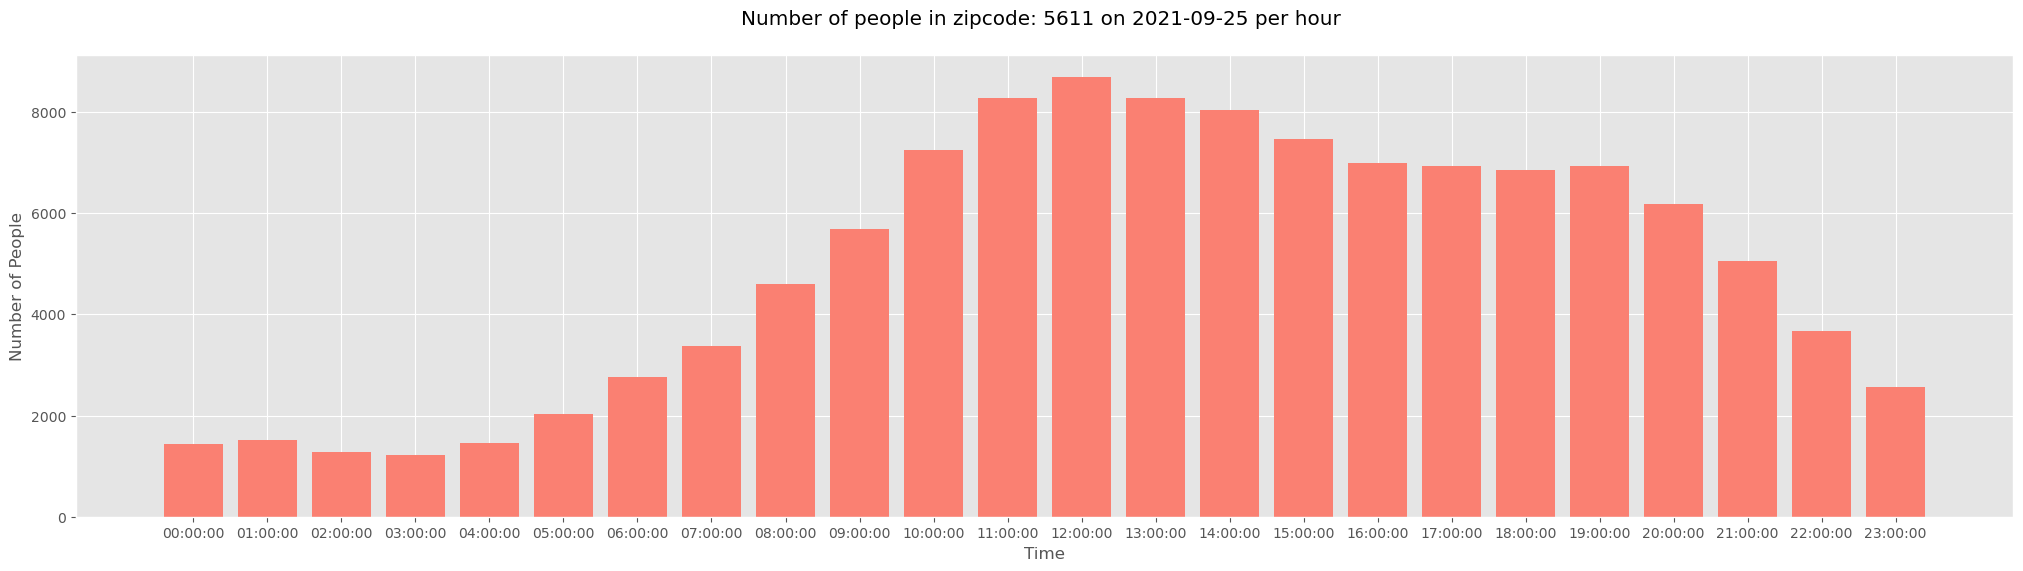

In [16]:
fig, ax = plt.subplots(figsize=(25, 6))
# Plot the data
scatter = ax.bar(list(people_air_quality_area["time"]),
                list(people_air_quality_area["pop_tot"]),
                color="salmon");

# Customize the plot
ax.set(title="Number of people in zipcode: 5611 on 2021-09-25 per hour \n",
      xlabel="Time",
      ylabel="Number of People");

<h4><font color=mediumvioletred> Get maximum number of people per zipcode </font></h4>

In [17]:
max_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg("max").reset_index()
max_people.head()

,PC4,pop_tot
0,5611,11617
1,5612,10250
2,5613,5925
3,5614,3504
4,5615,4408


<h4><font color=mediumvioletred> Visualize maximum number of people per zipcode </font></h4>

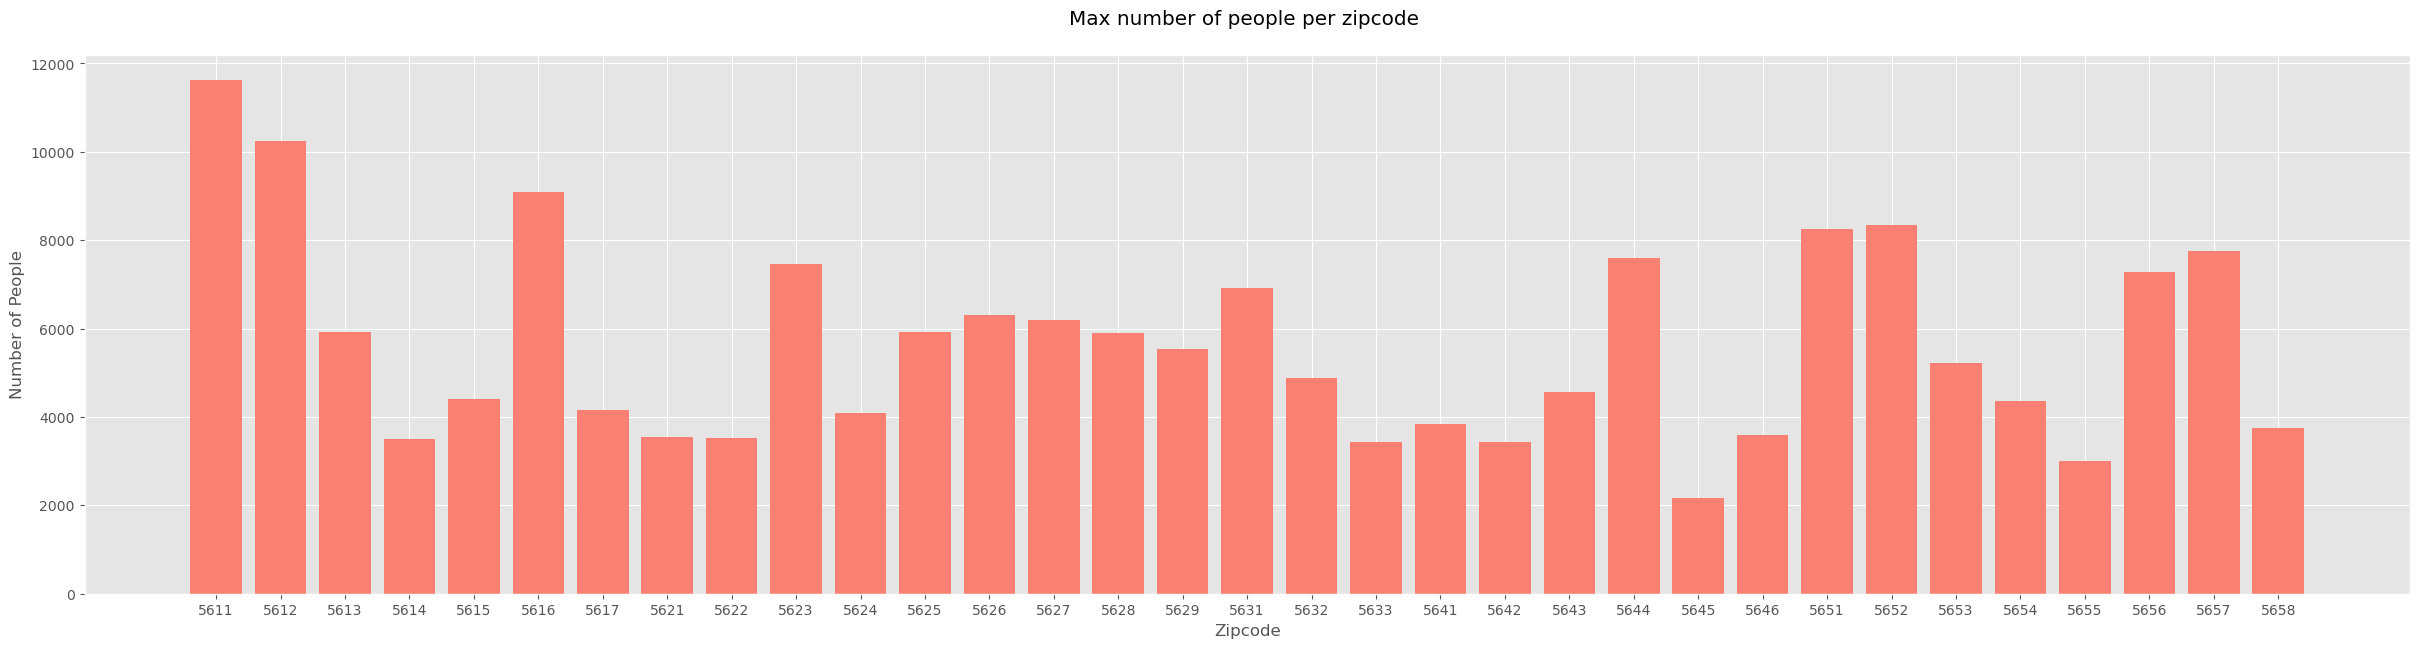

In [18]:
fig, ax = plt.subplots(figsize=(30, 7))
# Plot the data
scatter = ax.bar(max_people["PC4"].astype(str),
                max_people["pop_tot"],
                color="salmon");

# Customize the plot
ax.set(title="Max number of people per zipcode \n",
      xlabel="Zipcode",
      ylabel="Number of people");

Zipcodes 5611, 5612, 5616 have the highest number of people.

<h4><font color=mediumvioletred> Get maximum, average and minimum number of people per zipcode </font></h4>

In [19]:
max_mean_min_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_people.head()

,PC4,max,min,mean
0,5611,11617,708,4676.526515
1,5612,10250,737,4052.258333
2,5613,5925,537,2504.754545
3,5614,3504,217,1509.311364
4,5615,4408,394,1933.862121


<h4><font color=mediumvioletred> Visualize maximum, average and minimum number of people per zipcode </font></h4>

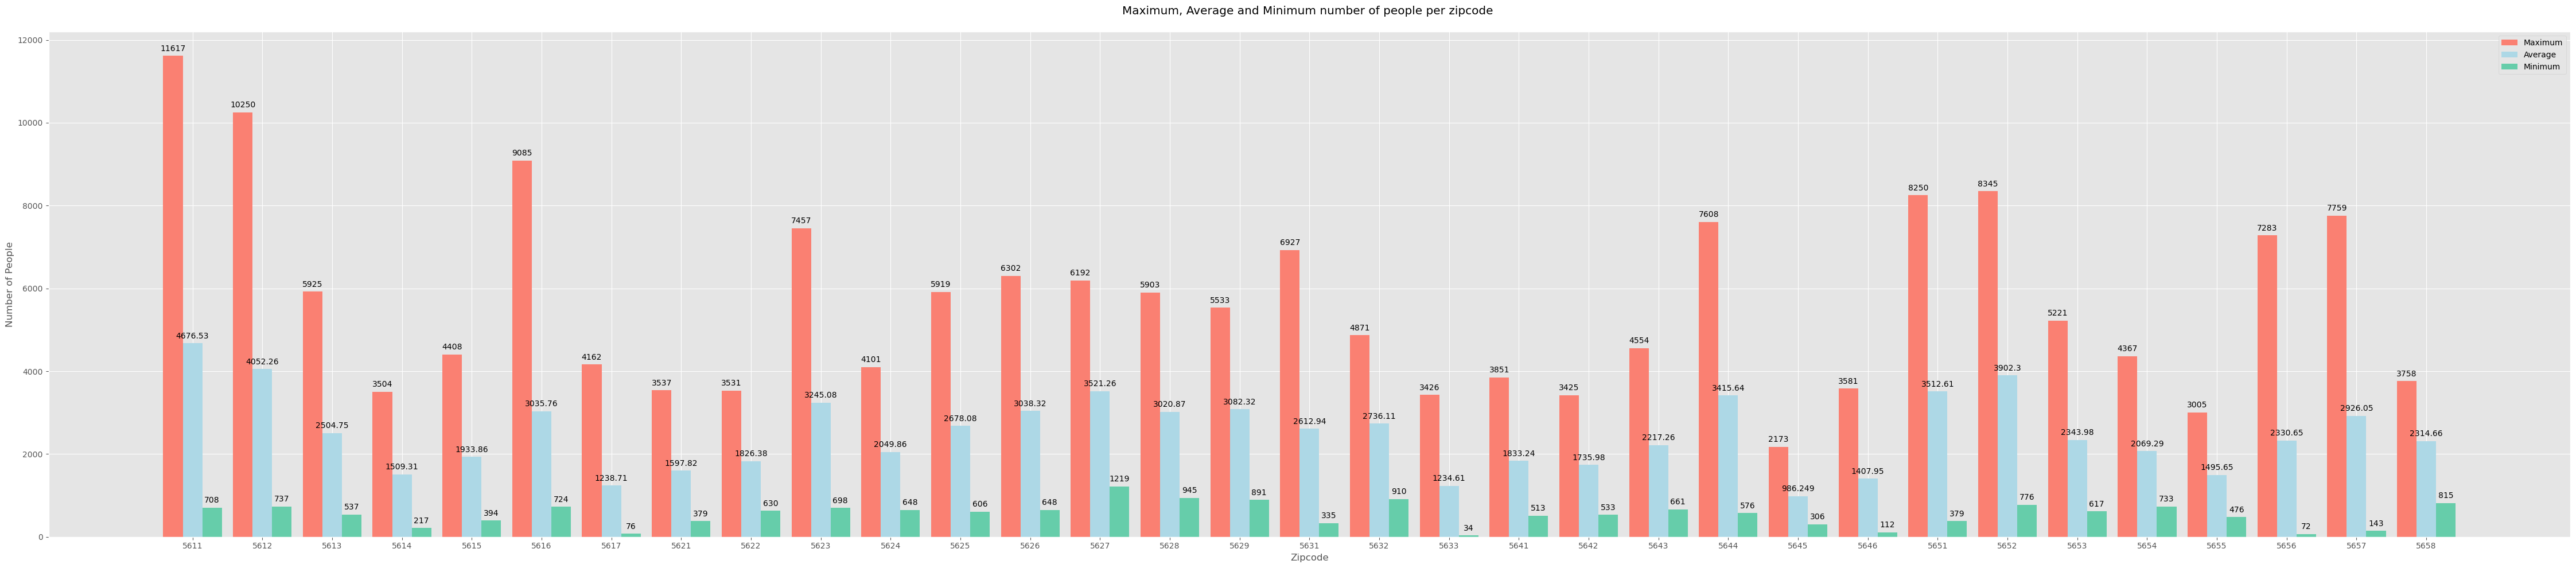

In [20]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_people["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, max_mean_min_people["max"], width, label="Maximum", color="salmon")
rects2 = ax.bar(x, max_mean_min_people["mean"], width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, max_mean_min_people["min"], width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Number of people")
ax.set_xlabel("Zipcode")
ax.set_title("Maximum, average and minimum number of people per zipcode \n")
ax.set_xticks(x, max_mean_min_people["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

plt.show()

Zipcodes 5611, 5612, 5616 have the highest number of people and zipcodes 5633, 5656, 5617 have the lowest number of people.

<h4><font color=mediumvioletred> Get number of people vs. air quality </font></h4>

In [21]:
# get data for zipcode 5611 on 2021-09-25
people_air_quality_area.head(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
0,5611,2021-09-25 00:00:00,1438,4.531522,155.0,0.0,0.0,0.0,0.0,77.0,1206.0,2021-09-25,00:00:00
1,5611,2021-09-25 01:00:00,1516,3.434374,130.0,0.0,0.0,0.0,29.0,72.0,1285.0,2021-09-25,01:00:00
2,5611,2021-09-25 02:00:00,1283,4.274056,44.0,0.0,0.0,0.0,15.0,73.0,1151.0,2021-09-25,02:00:00
3,5611,2021-09-25 03:00:00,1223,5.396931,14.0,0.0,0.0,14.0,14.0,86.0,1095.0,2021-09-25,03:00:00
4,5611,2021-09-25 04:00:00,1464,6.389200,56.0,0.0,14.0,28.0,28.0,155.0,1183.0,2021-09-25,04:00:00


<h4><font color=mediumvioletred> Visualize number of people vs. air quality </font></h4>

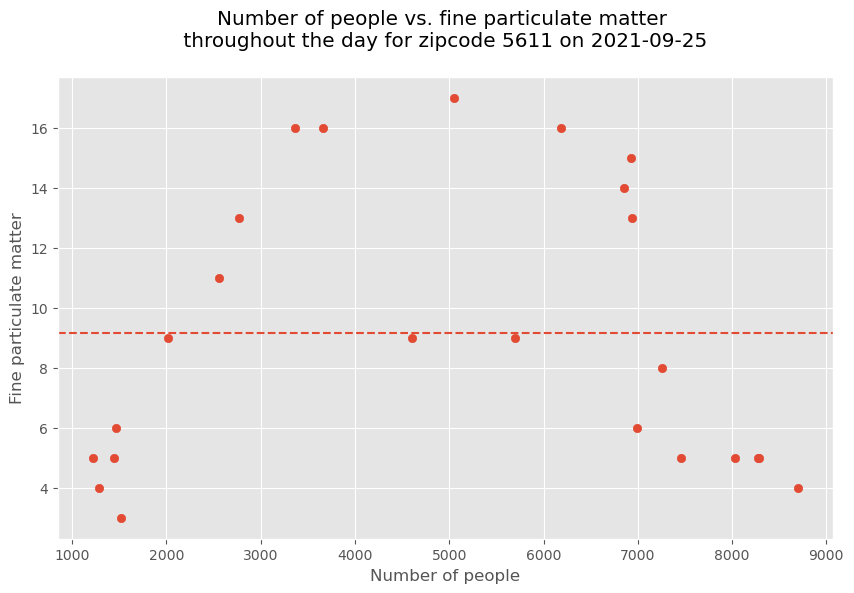

In [22]:
# Number of people vs. fine particulate matter in a day in a specific area
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
scatter = ax.scatter(x=people_air_quality_area["pop_tot"],
                    y=round(people_air_quality_area["pm2.5"]),
                    cmap="winter"); # color map: this changes the color scheme

# Customize the plot
ax.set(title="Number of people vs. fine particulate matter \n throughout the day for zipcode 5611 on 2021-09-25 \n",
      xlabel="Number of people",
      ylabel="Fine particulate matter");

# Add a horizontal line
ax.axhline(people_air_quality_area["pm2.5"].mean(),
          linestyle="--");

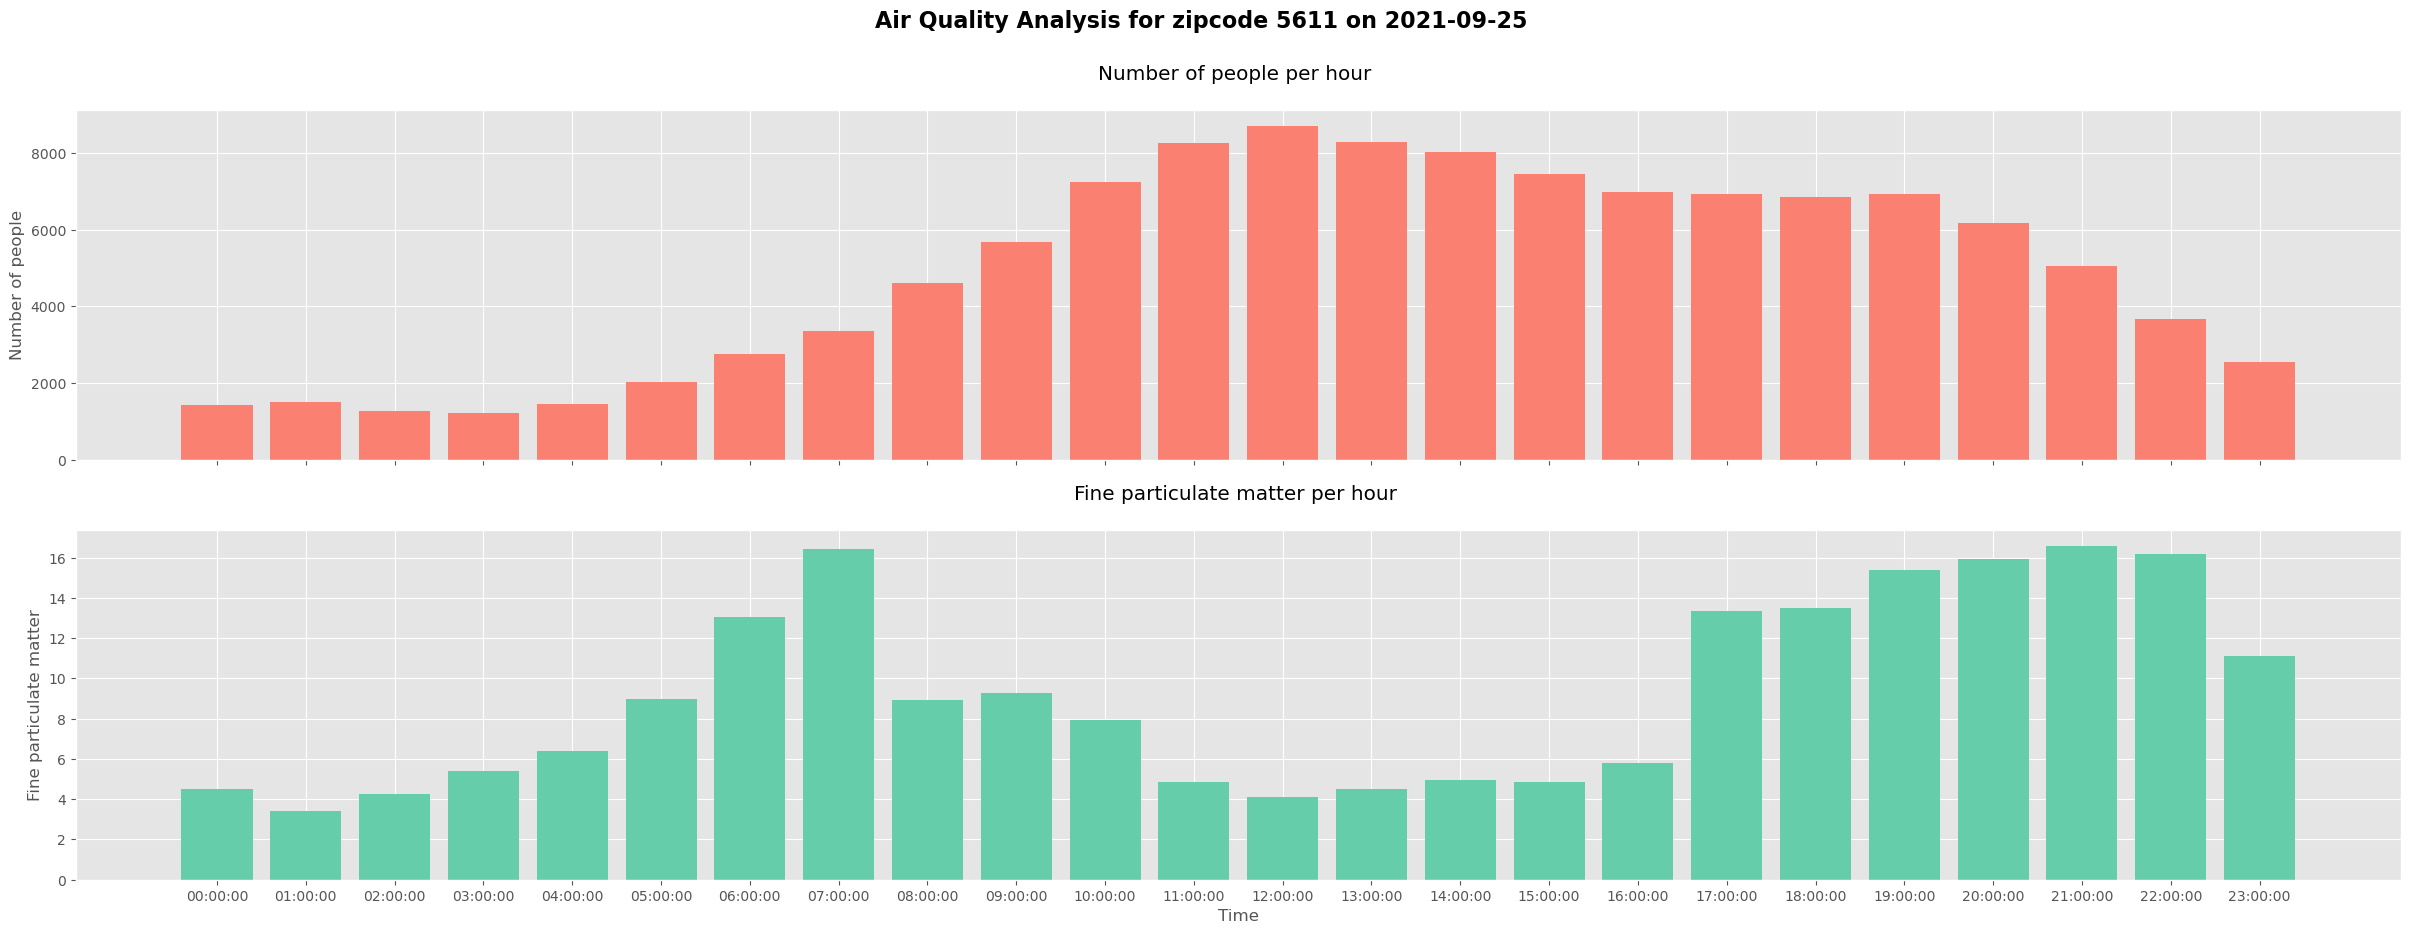

In [23]:
# Subplot of number of people, pollution, time
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 10),
                                sharex=True)

# Add data to ax0
ax0.bar(people_air_quality_area["time"], people_air_quality_area["pop_tot"], color="salmon");
# Add data to ax1
ax1.bar(people_air_quality_area["time"], people_air_quality_area["pm2.5"], color="mediumaquamarine");

# Customize ax0
ax0.set(title="Number of people per hour \n",
      ylabel="Number of people");

# Customize ax1
ax1.set(title="Fine particulate matter per hour \n",
        xlabel="Time",
        ylabel="Fine particulate matter");

# Add a title to the figure
fig.suptitle("Air Quality Analysis for zipcode 5611 on 2021-09-25", fontsize=16, fontweight="bold");

<h4><font color=mediumvioletred> Get maximum, average and minimum fine particulate matter per zipcode </font></h4>

In [24]:
# Get daily average of pm2.5 per zipcode
average_pm_per_day = df_zichtop_air_pollution.groupby(["PC4", "date"])["pm2.5"].agg({"mean"}).reset_index()

# Get maximum, average and minimum of pm2.5 per zipcode
max_mean_min_pm = average_pm_per_day.groupby(["PC4"])["mean"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_pm.head()

,PC4,max,min,mean
0,5611,36.353814,2.800860,11.384660
1,5612,36.713622,2.803116,11.319719
2,5613,33.850463,2.651556,10.836317
3,5614,33.032114,2.573862,10.658091
4,5615,35.662240,2.660535,11.044525


<h4><font color=mediumvioletred> Visualize maximum, average and minimum fine particulate matter per zipcode </font></h4>

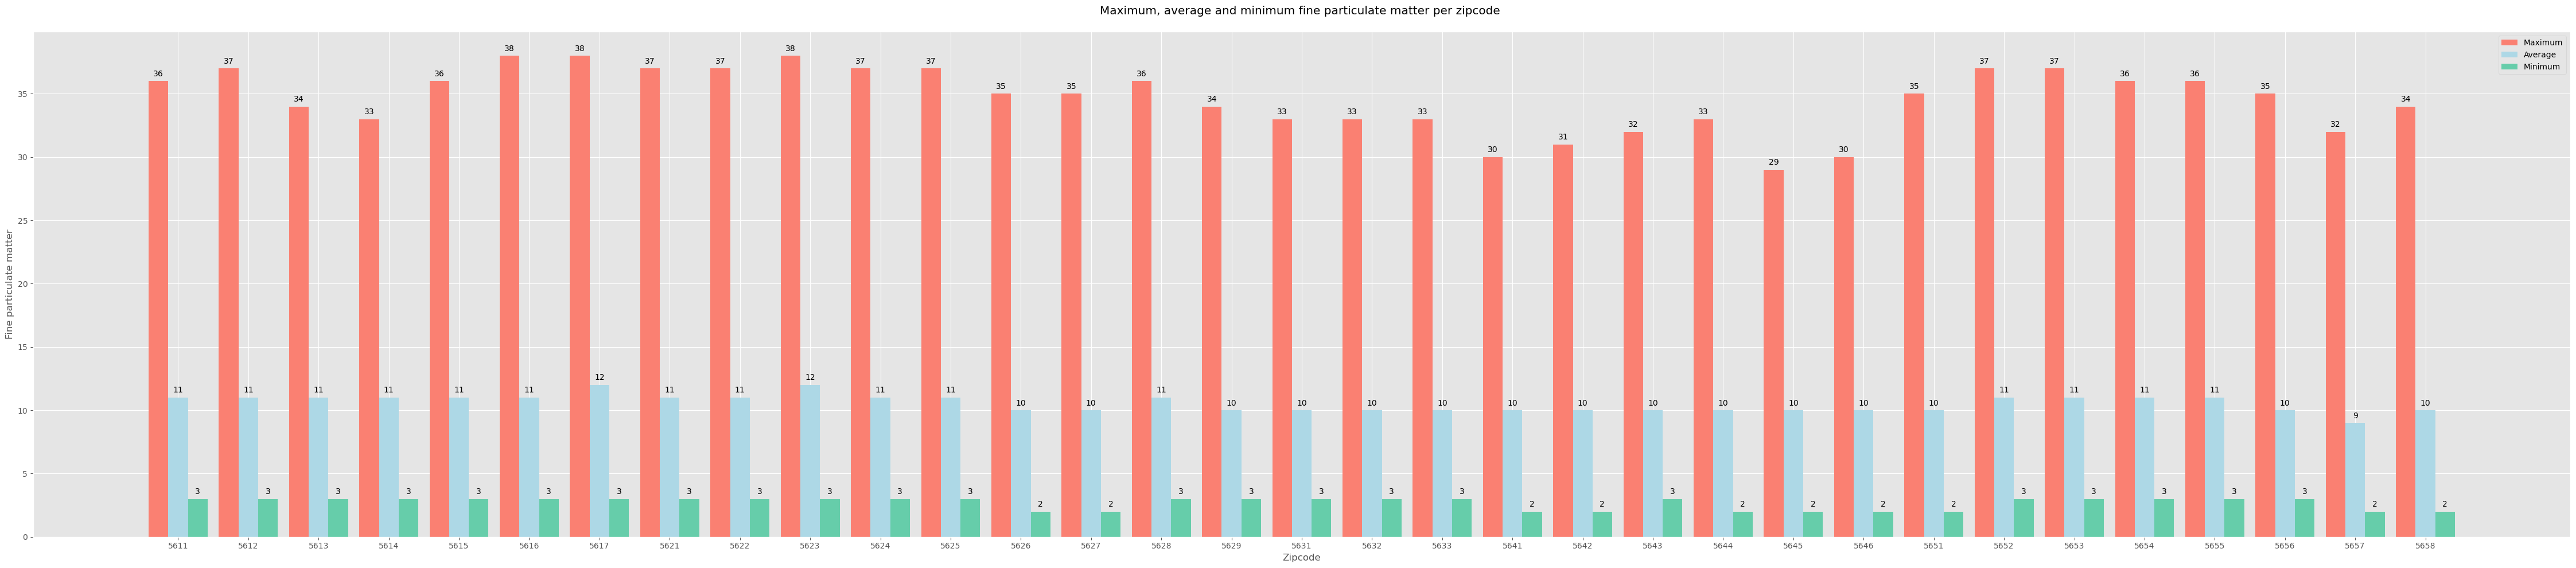

In [25]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_pm["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, round(max_mean_min_pm["max"]), width, label="Maximum", color="salmon")
rects2 = ax.bar(x, round(max_mean_min_pm["mean"]), width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, round(max_mean_min_pm["min"]), width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Fine particulate matter")
ax.set_xlabel("Zipcode")
ax.set_title("Maximum, average and minimum fine particulate matter per zipcode \n")
ax.set_xticks(x, max_mean_min_pm["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

plt.show()

According to the following diagram the maximum pm2.5 for each zipcode are on a moderate/unhealthy level and the average and minimum pm2.5 are on a good level.

![title](images/pm2.5_chart.jpg)

<h2><font color=slateblue> 5. Data Preparation </font></h2>

<h2><font color=slateblue> 6. Modelling </font></h2>